# Extract Device Benchmarks

Extract benchmarks like Layer Fidelity (LF), Error per Layered Gate (EPLG), and 2Q errors. This notebook can be easily adjusted to extract any other type of device information.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import re
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_gate_map
from scipy import stats

# Get backends

In [ ]:
# load service
service = QiskitRuntimeService()

In [80]:
# Specify a lits of backends
backend_names = ['ibm_torino', 'ibm_sherbrooke', 'ibm_osaka']

In [81]:
# Get inidividual backends
backends = {}
for machine in backend_names:
    backend = service.backend(machine, instance='')
    backends[machine] = backend  

# Extract backend information

In [82]:
# Get Layer Fidelity (lf) data from backend properties
qchains = {}
lengths = {}
lfs = {}
eplgs = {}
for machine in backend_names:
    backend = backends[machine]
    # retrieve the best 100Q chain
    qchains[machine] = backend.properties().general_qlists[0]['qubits']
    # retrieve lf array
    length = []
    lf = []
    for prop in backend.properties().general:
        prop_dict = prop.to_dict()
        if 'lf' in prop_dict ['name']:
            l = int(re.findall(r'\d+', prop_dict ['name'])[0])
            length.append(l)
            lf.append(prop_dict ['value'])
    lfs[machine] = lf
    lengths[machine] = length
    num_2q_gates = [l - 1 for l in length]
    # calculate eplg array from lf
    eplg = [1 - (fid ** (1 / num_2q)) for num_2q, fid in zip(num_2q_gates, lf)]
    eplgs[machine] = eplg  

# Plot LF and EPLG data

In [83]:
# Define plot colors and markers
markers = ['o','s','v', 'p', '*', 'd', 'x']
colors =  ['blue', 'deeppink', 'green', 'red', 'gold', 'brown', 
          'steelblue', 'gray', 'lightgreen', 'darkmagenta', 'orange', 'lightskyblue', 'royalblue']

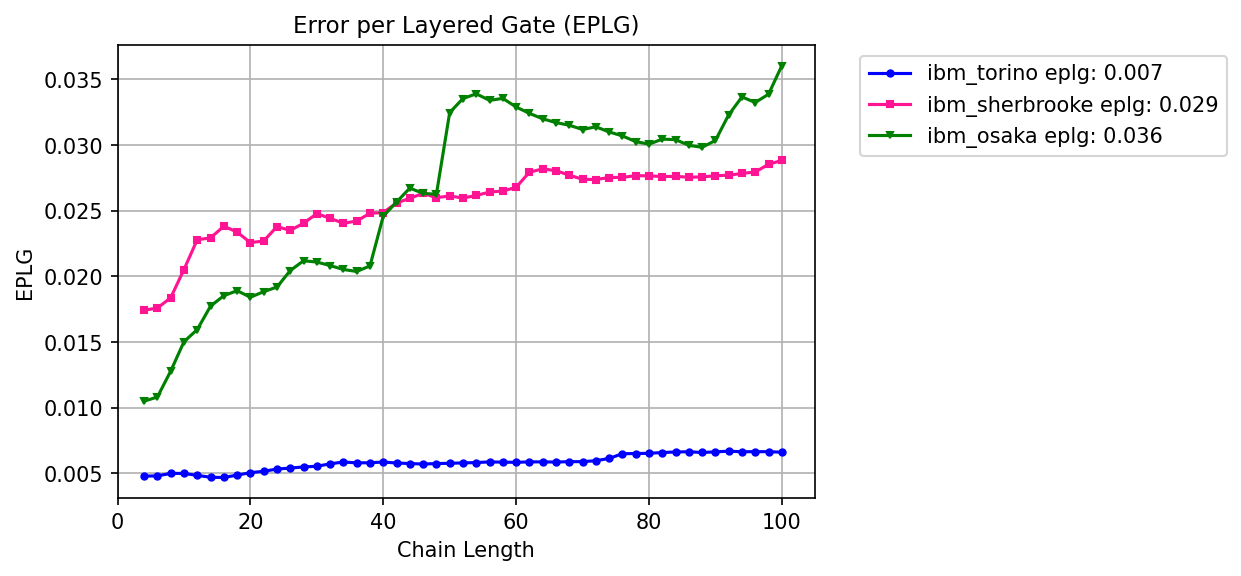

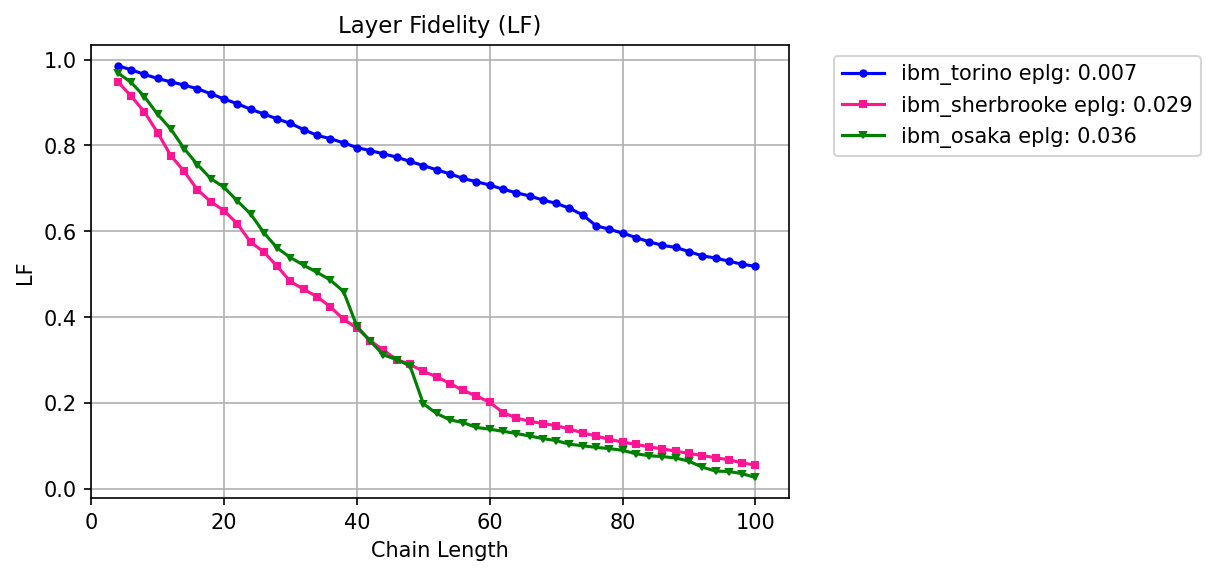

In [84]:
# Plot lf and eplg data per device
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
for i, machine in enumerate(backend_names):
    ax1.plot(lengths[machine], eplgs[machine], marker=markers[i % len(markers)], color=colors[i % len(colors)], markersize=3, linestyle="-", label= f'{machine} eplg: {round(eplgs[machine][-1],3)}')
    ax2.plot(lengths[machine], lfs[machine], marker=markers[i % len(markers)], color=colors[i % len(colors)], markersize=3, linestyle="-", label= f'{machine} eplg: {round(eplgs[machine][-1],3)}')

ax1.set_title(f"Error per Layered Gate (EPLG)", fontsize=11)
ax1.set_xlim(0, lengths[machine][-1] * 1.05)
ax1.set_ylabel("EPLG")
ax1.set_xlabel("Chain Length")
ax1.grid()
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.figure.set_dpi(150)
# fig1.savefig('eplg.png', dpi=150, bbox_inches='tight')

ax2.set_title(f"Layer Fidelity (LF)", fontsize=11)
ax2.set_xlim(0, lengths[machine][-1] * 1.05)
ax2.set_ylabel("LF")
ax2.set_xlabel("Chain Length")
ax2.grid()
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.figure.set_dpi(150)
# fig2.savefig('lf.png', dpi=150, bbox_inches='tight')

# Print and plot the best 100Q chain for each backend

In [85]:
# Print the best 100Q chain per backend
for machine in backend_names:
    print(f'Best 100Q chain for {machine}:')
    print(qchains[machine])

Best 100Q chain for ibm_torino:
[19, 15, 0, 1, 2, 3, 4, 16, 23, 24, 25, 35, 44, 43, 42, 41, 40, 39, 38, 53, 57, 58, 59, 72, 78, 77, 76, 91, 95, 96, 97, 110, 116, 117, 118, 119, 120, 111, 101, 100, 99, 92, 80, 81, 82, 73, 63, 64, 65, 55, 46, 47, 48, 36, 29, 28, 27, 17, 8, 9, 10, 11, 12, 18, 31, 32, 33, 37, 52, 51, 50, 56, 69, 70, 71, 75, 90, 89, 88, 94, 107, 108, 109, 113, 128, 127, 126, 125, 124, 112, 105, 104, 103, 93, 84, 85, 86, 74, 67, 66]
Best 100Q chain for ibm_sherbrooke:
[10, 11, 12, 17, 30, 31, 32, 36, 51, 50, 49, 55, 68, 69, 70, 74, 89, 88, 87, 86, 85, 73, 66, 65, 64, 54, 45, 46, 47, 35, 28, 27, 26, 16, 8, 7, 6, 5, 4, 3, 2, 1, 0, 14, 18, 19, 20, 21, 22, 23, 24, 34, 43, 42, 41, 53, 60, 61, 62, 72, 81, 82, 83, 92, 102, 103, 104, 105, 106, 107, 108, 112, 126, 125, 124, 123, 122, 121, 120, 119, 118, 117, 116, 115, 114, 109, 96, 95, 94, 90, 75, 76, 77, 78, 79, 91, 98, 99, 100, 101]
Best 100Q chain for ibm_osaka:
[26, 27, 28, 35, 47, 46, 45, 54, 64, 63, 62, 72, 81, 80, 79, 91, 98, 

100Q chain for ibm_osaka


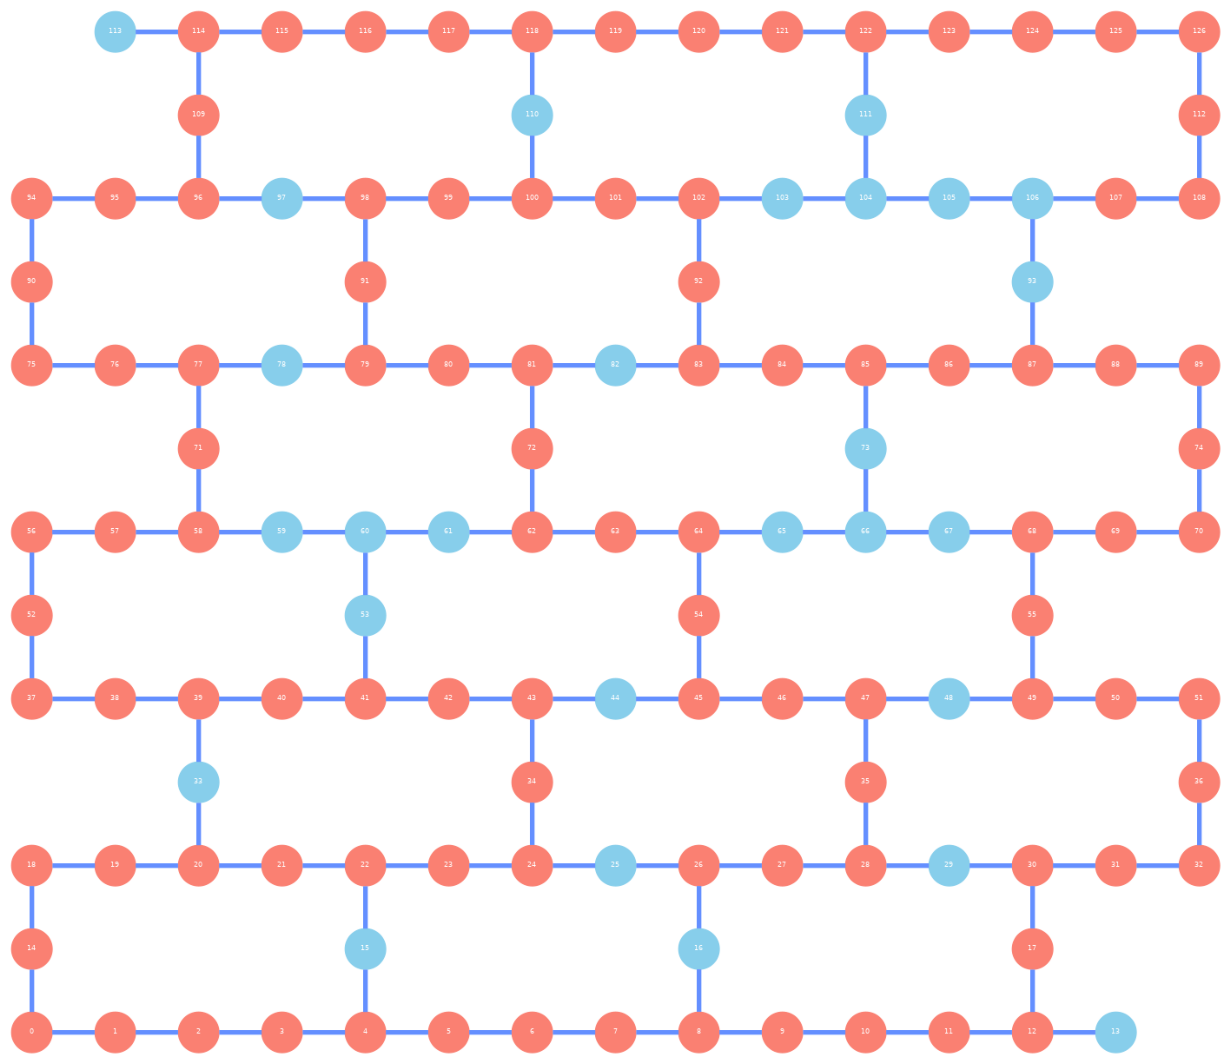

In [86]:
# Plot the best 100Q chain for a machine
machine = 'ibm_osaka'
print(f'100Q chain for {machine}')
qcolors = ['salmon' if i in qchains[machine] else 'skyblue' for i in range(0, backends[machine].configuration().n_qubits)]
plot_gate_map(backends[machine], label_qubits=True, qubit_color=qcolors)

# Plot 2Q error distribution for each backend

In [87]:
# Get 2q errors for each backend
tqerrors = {}
for machine in backend_names:
    # Get 2q gate
    backend = backends[machine]
    if "ecr" in backend.configuration().basis_gates:
        twoq_gate = "ecr"
    elif "cz" in backend.configuration().basis_gates:
        twoq_gate = "cz"
    else:
        twoq_gate = 'cx'

    # Extract 2q gate errors
    errors = []
    reset = []
    for gate in backend.properties().gates:
        gate_dict = gate.to_dict()
        if twoq_gate in gate_dict['gate']:
            error = gate_dict['parameters'][0]['value']
            errors.append(error)
    tqerrors[machine] = errors

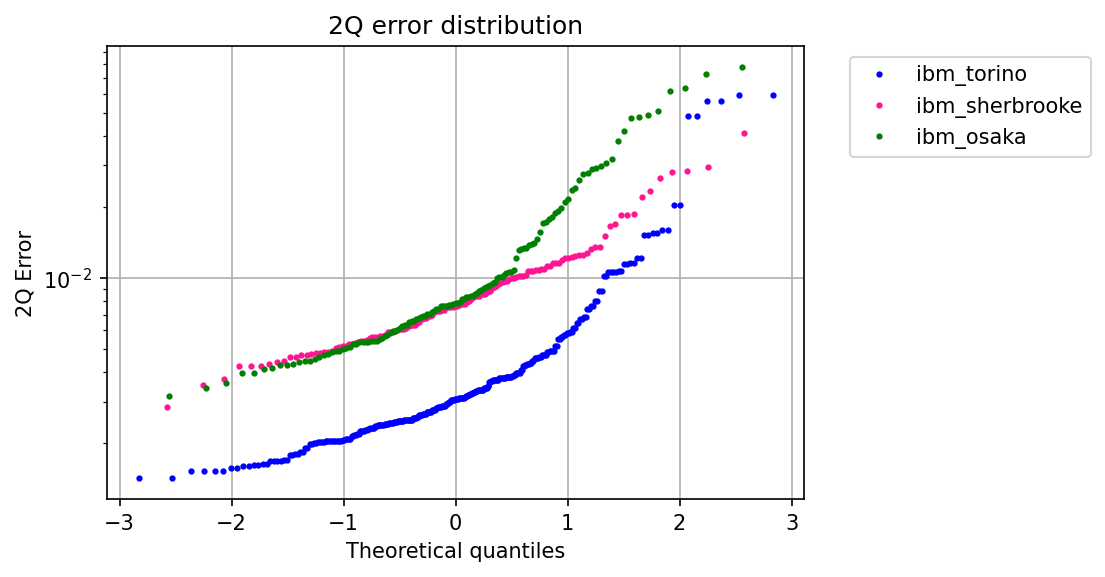

In [95]:
# Plot the distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
legend = []
for i, machine in enumerate(backend_names):
    errors = [x for x in tqerrors[machine] if 0<x<1] # clip values outside of normal range
    stats.probplot(errors, plot=plt, fit=False)
    ax.get_lines()[i].set_color(colors[i%len(colors)])
    plt.setp(ax.get_lines()[i], markersize=2)  #
    legend.append(machine)
ax.legend(legend, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title('2Q error distribution')
ax.set_ylabel('2Q Error')
ax.figure.set_dpi(150)
plt.yscale('log')
plt.grid()
plt.show()

# Plot 1Q distributions for each backend

In [89]:
# Specify list of properties for each backend
prop_list = ['T1','T2','1Q Error','Readout Error']
prop_unit = ['us','us','','']
prop_scale = [1e-6,1e-6,1,1]

In [90]:
def get_1q_distributions(backends, backend_names, prop_ind=0):
    oneqprops = {}
    for machine in backend_names:
        backend = backends[machine]
        nq = backend.configuration().n_qubits # number of qubits

        # Extract 1Q properties
        props = []
        for qnum in range(nq):
            if prop_ind==0:
                props.append(backend.properties().t1(qnum))
            elif prop_ind==1:
                props.append(backend.properties().t2(qnum))
            elif prop_ind==2:
                props.append(backend.properties().gate_error('sx',qnum))
            elif prop_ind==3:
                props.append(backend.properties().readout_error(qnum))
            else:
                raise ValueError('Not a valid property selection, prop_ind must be < %d'%len(prop_list))
        oneqprops[machine] = props
    return oneqprops

def plot_1q_distribution(backend_names, oneqprops, prop_list, prop_unit, prop_ind=0):
    # Plot the distribution
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    legend = []
    for i, machine in enumerate(backend_names):
        #errors = [x for x in oneqprops[machine] if 0<x<1] # clip values outside of normal range
        stats.probplot(np.array(oneqprops[machine])/prop_scale[prop_ind], plot=plt, fit=False)
        ax.get_lines()[i].set_color(colors[i%len(colors)])
        plt.setp(ax.get_lines()[i], markersize=2)  #
        legend.append(machine)
    ax.legend(legend, bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_title('%s distribution'%prop_list[prop_ind])
    if len(prop_unit[prop_ind])>0:
        ax.set_ylabel('%s (%s)'%(prop_list[prop_ind],prop_unit[prop_ind]))
    else:
        ax.set_ylabel('%s'%(prop_list[prop_ind]))
    ax.figure.set_dpi(150)
    ax.set_yscale('log')
    plt.grid()
    plt.show()

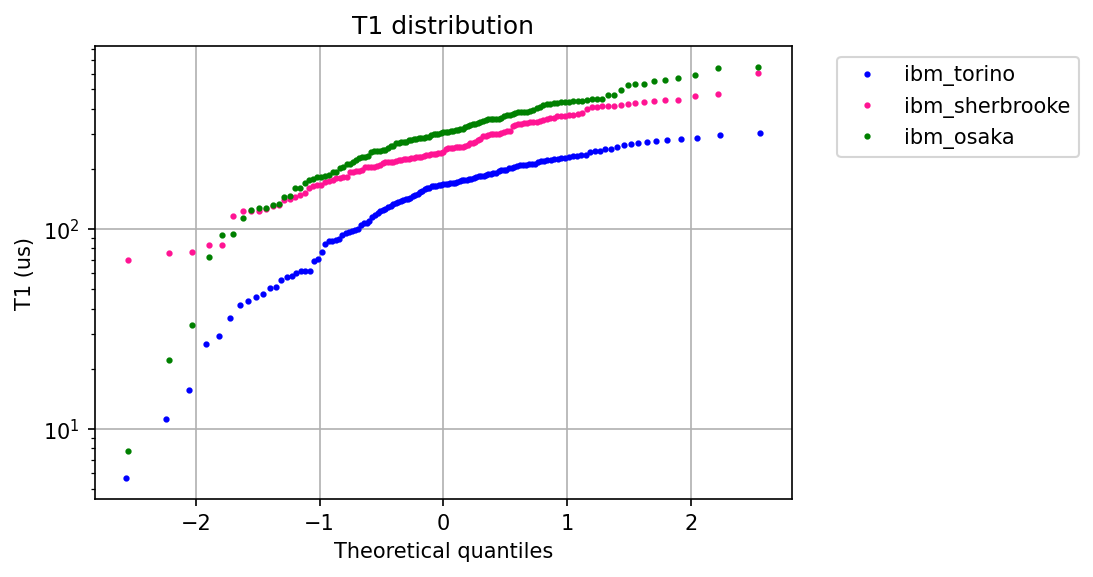

In [91]:
# Plot T1 distribution
oneqprops = get_1q_distributions(backends, backend_names, prop_ind=0)
plot_1q_distribution(backend_names, oneqprops, prop_list, prop_unit, prop_ind=0)

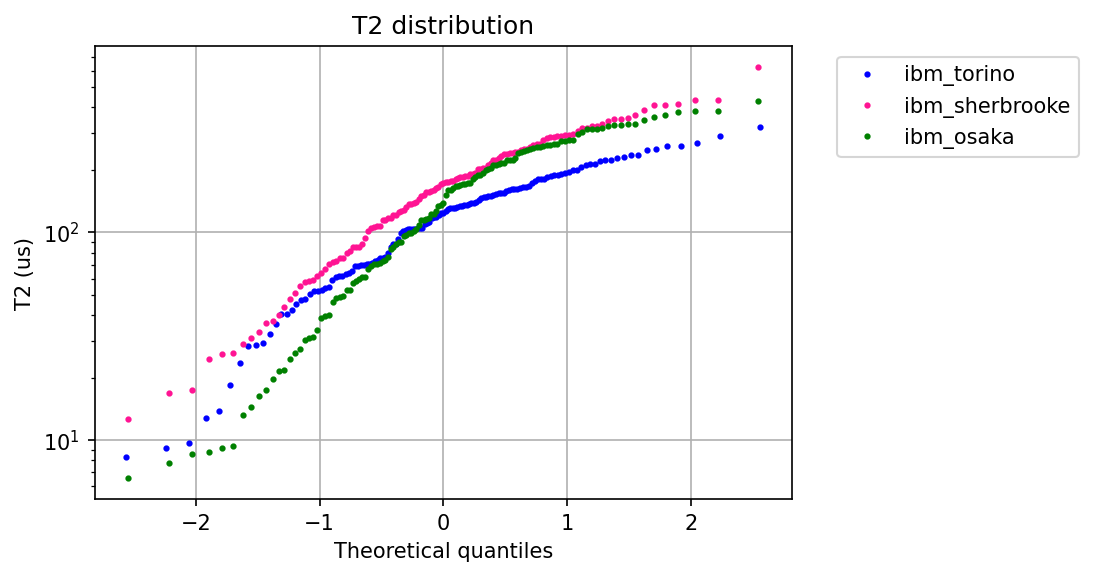

In [92]:
# Plot T2 distribution
oneqprops = get_1q_distributions(backends, backend_names, prop_ind=1)
plot_1q_distribution(backend_names, oneqprops, prop_list, prop_unit, prop_ind=1)

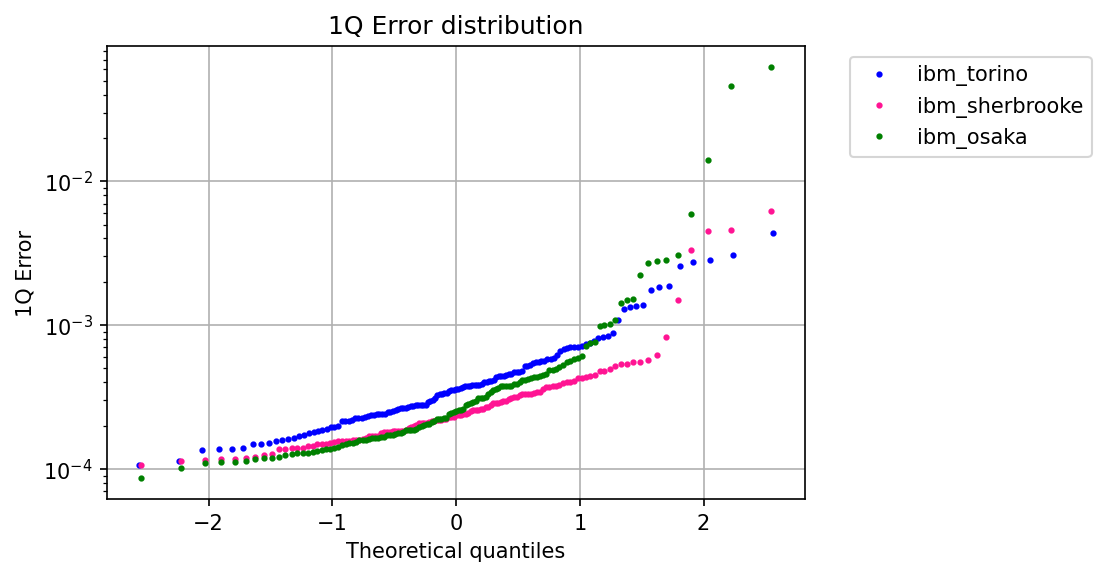

In [93]:
# Plot 1Q distribution
oneqprops = get_1q_distributions(backends, backend_names, prop_ind=2)
plot_1q_distribution(backend_names, oneqprops, prop_list, prop_unit, prop_ind=2)

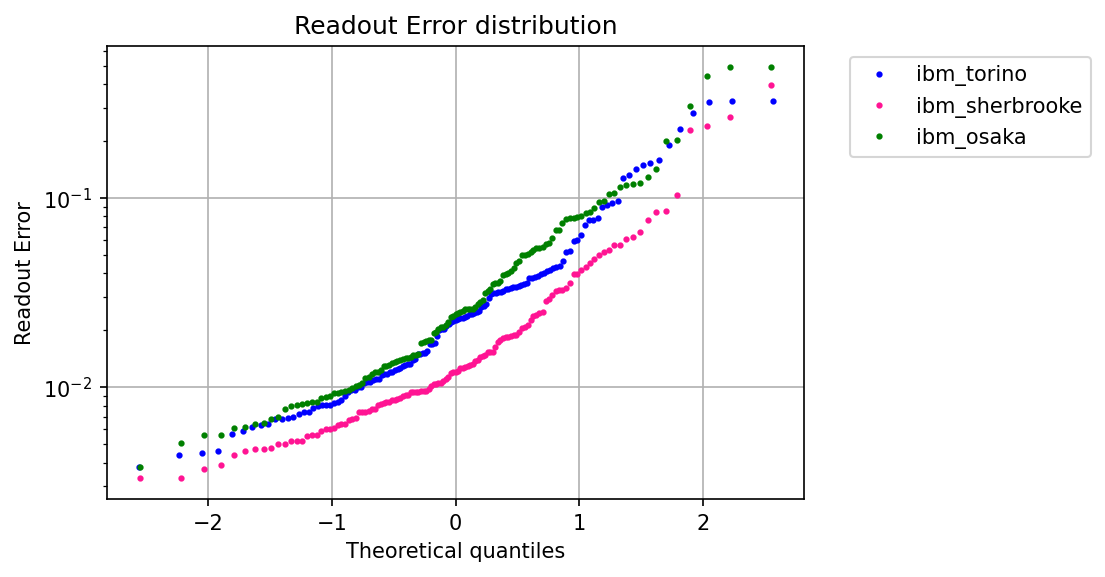

In [94]:
# Plot Readout distribution
oneqprops = get_1q_distributions(backends, backend_names, prop_ind=3)
plot_1q_distribution(backend_names, oneqprops, prop_list, prop_unit, prop_ind=3)

# Copyrights

In [74]:
import datetime
from IPython.display import HTML, display

def qiskit_copyright(line="", cell=None):
    """IBM copyright"""
    now = datetime.datetime.now()

    html = "<div style='width: 100%; background-color:#d5d9e0;"
    html += "padding-left: 10px; padding-bottom: 10px; padding-right: 10px; padding-top: 5px'>"
    html += "<p>&copy; Copyright IBM 2017, %s.</p>" % now.year
    html += "<p>This code is licensed under the Apache License, Version 2.0. You may<br>"
    html += "obtain a copy of this license in the LICENSE.txt file in the root directory<br> "
    html += "of this source tree or at http://www.apache.org/licenses/LICENSE-2.0."

    html += "<p>Any modifications or derivative works of this code must retain this<br>"
    html += "copyright notice, and modified files need to carry a notice indicating<br>"
    html += "that they have been altered from the originals.</p>"
    html += "</div>"
    return display(HTML(html))

qiskit_copyright()